In [15]:
import os as os
import warnings as warnings
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import plotnine as gg

import sklearn as sk
import statsmodels.api as sm

from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Imputer, PolynomialFeatures, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble.partial_dependence import plot_partial_dependence

from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator
from pgmpy.inference import VariableElimination

pd.options.display.max_rows = 1000
gg.theme_set(gg.theme_seaborn())

# Data

In [23]:
df = pd.read_csv('../data/engineered_factset_campaign.csv', parse_dates=['campaign_announcement_date'])

df_objective_mapping = pd.read_csv('../mapping/campaign_mapping.csv')
df_value_mapping = pd.read_csv('../mapping/value_demand_mapping.csv')
df_governance_mapping = pd.read_csv('../mapping/governance_demand_mapping.csv')
df_result_mapping = pd.read_csv('../mapping/proxy_result_mapping.csv')
df_tweet_count = pd.read_csv('../data/twitter_count.csv')

df = (
    df
    .pipe(pd.merge, df_objective_mapping, how='left', on='campaign_objective_primary')
    .pipe(pd.merge, df_value_mapping, how='left', on='value_demand')
    .pipe(pd.merge, df_governance_mapping, how='left', on='governance_demand')
    .pipe(pd.merge, df_result_mapping, how='left', on='proxy_campaign_winner_or_result')
    .pipe(pd.merge, df_tweet_count[['campaign_id', 'tweet_count']], how='left', on='campaign_id')
    .assign(tweet_count=lambda df: df.tweet_count.fillna(0))
    .assign(has_many_tweets=lambda df: df.tweet_count >= 20)
)

df = (
    df
    
    .assign(has_past_return_successes_indicator=lambda df: 1 * (df.past_return_successes.fillna(0) > 0))
    .assign(has_value_demand=lambda df: 1 * df.value_demand.notnull())
    .assign(has_governance_demand=lambda df: 1 * df.governance_demand.notnull())
    
    .assign(campaign_objective_group=lambda df: df.campaign_objective_group.fillna('(Missing)'))
    .assign(value_demand_group=lambda df: df.value_demand_group.fillna('(Missing)'))
    .assign(governance_demand_group=lambda df: df.governance_demand_group.fillna('(Missing)'))
    
    .assign(glass_lewis_support_indicator=lambda df: 1 * (df.glass_lewis_support == 'Management').fillna(0))
    .assign(iss_support_indicator=lambda df: 1 * (df.iss_support == 'Management').fillna(0))
    .assign(independent_support_indicator=lambda df: 1 * (df.glass_lewis_support_indicator | df.iss_support_indicator))
    
    .assign(poison_pill_indicator=lambda df: 1 * (df.poison_pill_in_force_prior_to_announcement  == "Yes").fillna(0))
    .assign(poison_pill_adopted_indicator=lambda df: 1 * (df.poison_pill_adopted_in_response_to_campaign == "Yes").fillna(0))

    .assign(ownership_percent_on_announcement=lambda df: df.ownership_pecent_on_announcement.fillna(0).clip(0, 0.20))
    .assign(ownership_percent_exceeds_5_indicator=lambda df: 1 * (df.ownership_pecent_on_announcement > 0.05).fillna(0))
    
    .assign(campaign_outcome_is_management=lambda df: 1 * ((df.proxy_result_group == "Management") | (df.board_seat_result_group == "Management")))
    .assign(post_12m_residual_return=lambda df: df.post_12m_residual_return.clip(-0.30, 0.30))
    .assign(cumulative_6m_residual_return=lambda df: df.cumulative_6m_residual_return.clip(-0.30, 0.30))
    .assign(campaign_return=lambda df: df.cumulative_6m_residual_return)
    .assign(campaign_return_is_positive=lambda df: np.where(df.campaign_return.isnull(), np.nan, 1 * (df.campaign_return > 0)))

)

df_original = df.copy()

In [24]:
df = pd.get_dummies(
    df,
    columns=['campaign_objective_group'],
    prefix='campaign_objective',
    prefix_sep='=',
    drop_first=True,
    dummy_na=False
)

df = pd.get_dummies(
    df,
    columns=['value_demand_group'],
    prefix='value_demand',
    prefix_sep='=',
    drop_first=True,
    dummy_na=False
)

df = pd.get_dummies(
    df,
    columns=['governance_demand_group'],
    prefix='governance_demand',
    prefix_sep='=',
    drop_first=True,
    dummy_na=False
)

df = pd.get_dummies(
    df,
    columns=['proxy_result_group'],
    prefix='proxy_result',
    prefix_sep='=',
    drop_first=True,
    dummy_na=False
)

df = pd.get_dummies(
    df,
    columns=['board_seat_result_group'],
    prefix='board_result',
    prefix_sep='=',
    drop_first=True,
    dummy_na=False
)

In [ ]:
df.campaign_return.isnull().sum()

In [ ]:
df.campaign_return_is_positive.isnull().sum()

In [ ]:
df.campaign_return_is_positive.unique()

In [ ]:
df.campaign_return_is_positive.value_counts(dropna=False)

In [ ]:
df.campaign_return_is_positive.describe()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002364A8690B8>]],
      dtype=object)

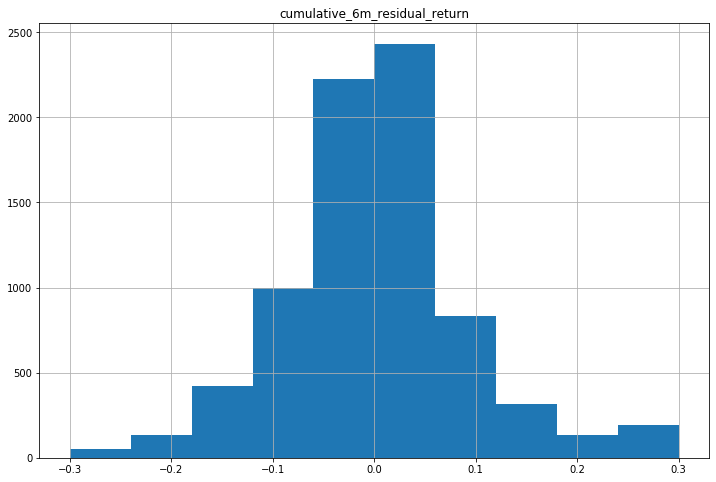

In [14]:
df.hist(column='cumulative_6m_residual_return', figsize=(12, 8))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002364A9EF898>]],
      dtype=object)

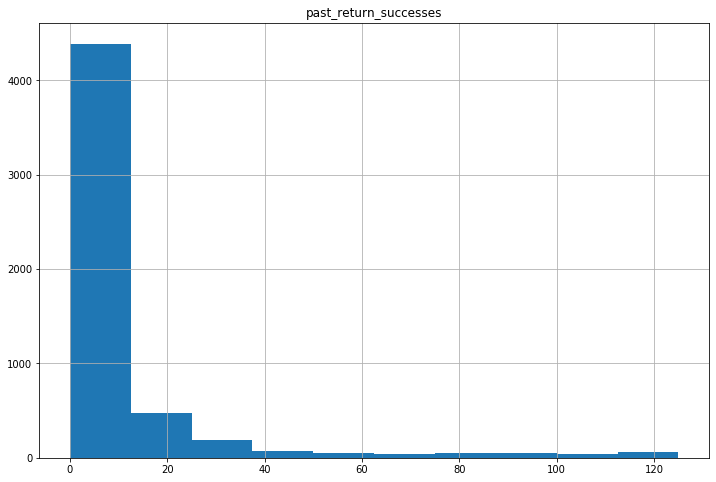

In [7]:
df.hist(column='past_return_successes', figsize=(12, 8))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025013C72C88>]],
      dtype=object)

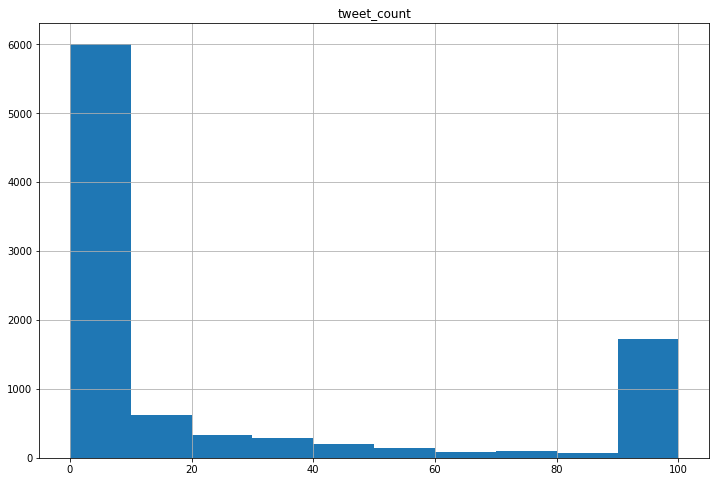

In [43]:
df.hist(column='tweet_count', figsize=(12, 8))

In [ ]:
df_original.dtypes.to_frame().to_clipboard()

# Models for Continuous Returns

In [38]:
x_columns = (
    [
        'ownership_percent_on_announcement',
        # 'ownership_percent_exceeds_5_indicator',
        'past_return_successes',
        # 'has_past_return_successes_indicator',
        'independent_support_indicator',
        # 'total_number_of_board_seats',
        'board_seats_percentage_sought',
        'poison_pill_indicator',
        'poison_pill_adopted_indicator',
        'pre_12m_earnings_yield',
        'tweet_count',
        # 'beta'
    ] +
    [c for c in df.columns.tolist() if 'used_' in c] +
    [c for c in df.columns.tolist() if 'campaign_objective=' in c] + 
    [c for c in df.columns.tolist() if 'value_demand=' in c] +
    [c for c in df.columns.tolist() if 'governance_demand=' in c]
)

y_column = [
    'campaign_return'
]

df_lm = df.dropna(subset=y_column)

df_train, df_test = train_test_split(df_lm, test_size=0.2, shuffle=True, random_state=42)
df_full = df_lm[x_columns + y_column]
X_train, y_train = df_train[x_columns], df_train[y_column]
X_test, y_test = df_test[x_columns], df_test[y_column]

n_samples, n_features = X_train.shape

In [39]:
print(f"Full data set has {len(df)} observations")
print(f"Regression data set has {len(df_full)} observations")
print("Train Feature shape: {}".format(X_train.shape))
print("Train Target shape: {}".format(y_train.shape))
print("Test Feature shape: {}".format(X_test.shape))
print("Test Target shape: {}".format(y_test.shape))

Full data set has 9571 observations
Regression data set has 7741 observations
Train Feature shape: (6192, 44)
Train Target shape: (6192, 1)
Test Feature shape: (1549, 44)
Test Target shape: (1549, 1)


# Linear Regression

### naive scikit

In [40]:
categorical_features = [c for c in df_full.dtypes[df_full.dtypes != float].index.tolist() if c not in y_column]
numeric_features = [c for c in df_full.dtypes[df_full.dtypes == float].index.tolist() if c not in y_column]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

preprocessor = ColumnTransformer(transformers=[
    ('numeric', numeric_transformer, numeric_features),
    ('categorical', categorical_transformer, categorical_features)
])

model = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])

fitted_model = model.fit(X_train, y_train)
y_predicted = fitted_model.predict(X_test)
df_predicted = df_test.assign(predicted_campaign_return=y_predicted)

r2_train = fitted_model.score(X_train, y_train)
r2_test = fitted_model.score(X_test, y_test)
print(f"Training set score is {r2_train}")
print(f"Test set score is {r2_test}")

Training set score is 0.026924853556403172
Test set score is 0.019383964511290763


C:\Users\micha\AppData\Local\Continuum\anaconda3\lib\site-packages\plotnine\scales\scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
C:\Users\micha\AppData\Local\Continuum\anaconda3\lib\site-packages\plotnine\utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


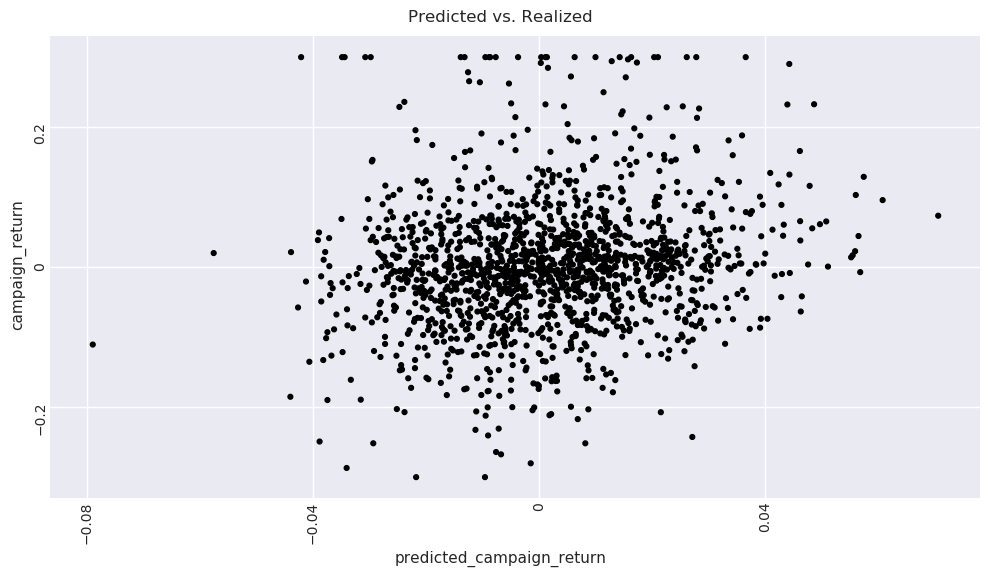

<ggplot: (152012647905)>

In [12]:
(
    gg.ggplot(df_predicted) +
    gg.geom_point(gg.aes(x='predicted_campaign_return', y='campaign_return')) +
    gg.theme(axis_text=gg.element_text(size=10, rotation=90), figure_size=(12, 6)) +
    gg.labs(
        title = "Predicted vs. Realized"
    )
)

C:\Users\micha\AppData\Local\Continuum\anaconda3\lib\site-packages\plotnine\scales\scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
C:\Users\micha\AppData\Local\Continuum\anaconda3\lib\site-packages\plotnine\utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


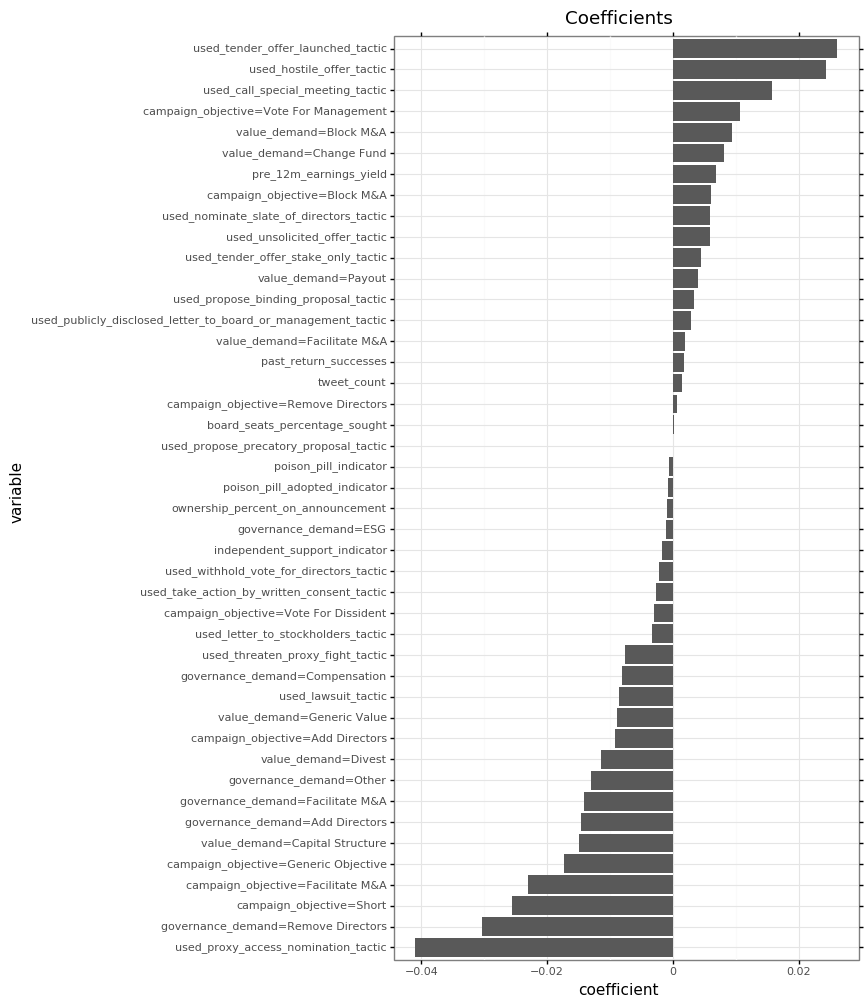

<ggplot: (-9223371884840581495)>

In [41]:
df_coefficients = (
    pd.DataFrame({
    'variable': X_train.columns.tolist(),
    'coefficient': model.named_steps['model'].coef_.flatten().tolist(),
    })
    .sort_values('coefficient')
    .assign(variable=lambda df: pd.Categorical(df.variable, categories=df.variable.tolist()))
)

(
    gg.ggplot(df_coefficients) +
    gg.geom_bar(gg.aes(x='variable', y='coefficient'), stat='identity', position='dodge') +
    gg.theme(axis_text=gg.element_text(size=8, rotation=0), figure_size=(6, 12)) +
    gg.coord_flip() +
    gg.labs(
        title = "Coefficients"
    )
)

### proper scikit

In [42]:
categorical_features = [c for c in df_full.dtypes[df_full.dtypes != float].index.tolist() if c not in y_column]
numeric_features = [c for c in df_full.dtypes[df_full.dtypes == float].index.tolist() if c not in y_column]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

preprocessor = ColumnTransformer(transformers=[
    ('numeric', numeric_transformer, numeric_features),
    ('categorical', categorical_transformer, categorical_features)
])

dict_model_pipelines = {
    "Model 1 - Linear Regression": [
        ("preprocessor", preprocessor),
        ("model", LinearRegression())
    ],
    "Model 2 - Ridge Regression": [
        ("preprocessor", preprocessor),
        ("model", Ridge())
    ],
    "Model 3 - Lasso Regression": [
        ("preprocessor", preprocessor),
        ("model", Lasso())
    ]
}

dict_model_parameter_grids = {
    "Model 1 - Linear Regression": {},
    "Model 2 - Ridge Regression": {
        'model__alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
    },
    "Model 3 - Lasso Regression": {
        'model__alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
    }
}

dict_grid_search_params = {
    "scoring": 'r2',
    "cv": 5,
    "refit": True,
    "iid": True
}

dict_cv_params = {
    "scoring": 'r2',
    "cv": 5
}

In [43]:
dict_models_baseline = {}
dict_grids = {}
dict_models_optimized = {}
dict_scores = {}
dict_train_predicted = {}
dict_test_predicted = {}

for model_name, model_pipeline_parameters in dict_model_pipelines.items():
    
    print('running model {}...'.format(model_name))
    print('=' * 100)
    print('')
    
    # model parameters
    
    pipeline_baseline_parameters = dict_model_pipelines[model_name].copy()
    grid_search_parameters = dict_model_parameter_grids[model_name].copy()
    pipeline_optimized_parameters = dict_model_pipelines[model_name].copy()  # will be updated
    
    # baseline fit on full training data
    
    model_pipeline_basline = Pipeline(pipeline_baseline_parameters)
    model_pipeline_basline = model_pipeline_basline.fit(X_train, y_train)

    params_baseline = model_pipeline_basline.get_params(deep=True)
    
    score_baseline_train = model_pipeline_basline.score(X_train, y_train)
    score_baseline_validation = np.mean(cross_val_score(model_pipeline_basline, X_train, y_train, **dict_cv_params))
    score_baseline_test = model_pipeline_basline.score(X_test, y_test)
    
    print('simple fit on training sample')
    print('-' * 80)
    print('')
    print('full-sample baseline parameters: {}'.format(params_baseline['model']))
    print('full-sample baseline train score: {}'.format(score_baseline_train))
    print('full-sample baseline validation score: {}'.format(score_baseline_validation))
    print('full-sample baseline test score: {}'.format(score_baseline_test))
    print('')
    
    # grid fit on cv-samples of training data

    model_grid_pipeline = Pipeline(pipeline_baseline_parameters)
    model_grid = GridSearchCV(model_grid_pipeline, param_grid=grid_search_parameters, **dict_grid_search_params)
    model_grid = model_grid.fit(X_train, y_train)
    
    params_grid_best = model_grid.best_params_.copy()
    
    score_grid_train = model_grid.score(X_train, y_train)
    score_grid_validation = np.mean(cross_val_score(model_grid, X_train, y_train, **dict_cv_params))
    score_grid_test = model_grid.score(X_test, y_test)

    print('cv fit on training sample')
    print('-' * 80)
    print('')
    print('grid-search-cv best parameters: {}'.format(params_grid_best))
    print('grid-search-cv best train score: {}'.format(score_grid_train))
    print('grid-search-cv best validation score: {}'.format(score_grid_validation))
    print('grid-search-cv best test score: {}'.format(score_grid_test))
    print('')
    
    # optimized fit on full training data
    
    model_pipeline_optimized = Pipeline(pipeline_optimized_parameters)
    model_pipeline_optimized.set_params(**params_grid_best)
    model_pipeline_optimized = model_pipeline_optimized.fit(X_train, y_train)

    params_optimized = model_pipeline_optimized.get_params(deep=True)
    
    score_optimized_train = model_pipeline_optimized.score(X_train, y_train)
    score_optimized_validation = np.mean(cross_val_score(model_pipeline_optimized, X_train, y_train, **dict_cv_params))
    score_optimized_test = model_pipeline_optimized.score(X_test, y_test)
    
    print('optimized fit on training sample')
    print('-' * 80)
    print('')
    print('full-sample optimized parameters: {}'.format(params_optimized['model']))
    print('full-sample optimized train score: {}'.format(score_optimized_train))
    print('full-sample optimized validation score: {}'.format(score_optimized_validation))
    print('full-sample optimized test score: {}'.format(score_optimized_test))
    print('')
    
    # final prediction
    
    y_train_predicted = model_pipeline_optimized.predict(X_train)
    y_test_predicted = model_pipeline_optimized.predict(X_test)
    
    df_train_predicted = df_train.assign(predicted_campaign_return=y_train_predicted).assign(model_name=model_name)
    df_test_predicted = df_test.assign(predicted_campaign_return=y_test_predicted).assign(model_name=model_name)

    # store
    dict_models_baseline[model_name] = model_pipeline_basline
    dict_grids[model_name] = model_grid.cv_results_
    dict_models_optimized[model_name] = model_pipeline_optimized
    dict_scores[model_name] = pd.DataFrame(
        columns=['IsTuned', 'Sample', 'Score'],
        data={
            'IsTuned': [
                False, False, False,
                True, True, True
            ],
            'Sample': [
                'Train', 'Validation', 'Test',
                'Train', 'Validation', 'Test'
            ],
            'Score': [
                score_baseline_train, score_baseline_validation, score_baseline_test,
                score_optimized_train, score_optimized_validation, score_optimized_test
            ]
        },
    ).set_index(['IsTuned', 'Sample'])
    dict_train_predicted[model_name] = df_train_predicted
    dict_test_predicted[model_name] = df_test_predicted

running model Model 1 - Linear Regression...

simple fit on training sample
--------------------------------------------------------------------------------

full-sample baseline parameters: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
full-sample baseline train score: 0.026924853556403172
full-sample baseline validation score: 0.009072029746886479
full-sample baseline test score: 0.019383964511290763

cv fit on training sample
--------------------------------------------------------------------------------

grid-search-cv best parameters: {}
grid-search-cv best train score: 0.026924853556403172
grid-search-cv best validation score: 0.009072029746886479
grid-search-cv best test score: 0.019383964511290763

optimized fit on training sample
--------------------------------------------------------------------------------

full-sample optimized parameters: LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
full-sample optimize

In [44]:
df_scores = pd.concat(dict_scores, names=['Model', 'IsTuned', 'Sample']).reset_index().loc[lambda df: df.IsTuned == True]
df_train_predictions = pd.concat(dict_train_predicted.values())
df_test_predictions = pd.concat(dict_test_predicted.values())

df_scores[['Model', 'Sample', 'Score']].set_index(['Model', 'Sample']).unstack('Sample')

Score                     
Sample                           Test     Train Validation
Model                                                     
Model 1 - Linear Regression  0.019384  0.026925   0.009072
Model 2 - Ridge Regression   0.019788  0.024416   0.012039
Model 3 - Lasso Regression   0.021028  0.025607   0.011938

In [55]:
df_predictions = pd.concat([df_train_predictions, df_test_predictions])
df_predictions.loc[lambda df: (df.predicted_campaign_return) > 0 & (df.campaign_return > 0)].loc[lambda df: df.activist_name.fillna('').str.contains('Icahn')].sort_values('campaign_announcement_date')

,campaign_id,campaign_announcement_date,campaign_title,campaign_objective_primary,value_demand,governance_demand,activist_campaign_tactic,total_number_of_board_seats,number_of_board_seats_sought,short_or_majority_or_full_slate,...,governance_demand=Compensation,governance_demand=ESG,governance_demand=Facilitate M&A,governance_demand=Other,governance_demand=Remove Directors,proxy_result=Dissident,proxy_result=Management,board_result=Management,predicted_campaign_return,model_name
12,1073547641C,1994-04-14,Icahn Enterprises L.P. / Carl C. Icahn,13D Filer - No Publicly Disclosed Activism,NaN,NaN,NaN,0,0,NaN,...,0,0,0,0,0,0,0,0,0.013449,Model 1 - Linear Regression
12,1073547641C,1994-04-14,Icahn Enterprises L.P. / Carl C. Icahn,13D Filer - No Publicly Disclosed Activism,NaN,NaN,NaN,0,0,NaN,...,0,0,0,0,0,0,0,0,0.009041,Model 2 - Ridge Regression
12,1073547641C,1994-04-14,Icahn Enterprises L.P. / Carl C. Icahn,13D Filer - No Publicly Disclosed Activism,NaN,NaN,NaN,0,0,NaN,...,0,0,0,0,0,0,0,0,0.010774,Model 3 - Lasso Regression
291,0672321035C,2000-02-04,Nabisco Group Holdings Corp. / Carl C. Icahn,Hostile/Unsolicited Acquisition,Potential Acquisition (Friendly and Unfriendly),NaN,"Publicly Disclosed Letter to Board/Management,...",0,0,NaN,...,0,0,0,0,0,0,0,0,0.025539,Model 3 - Lasso Regression
291,0672321035C,2000-02-04,Nabisco Group Holdings Corp. / Carl C. Icahn,Hostile/Unsolicited Acquisition,Potential Acquisition (Friendly and Unfriendly),NaN,"Publicly Disclosed Letter to Board/Management,...",0,0,NaN,...,0,0,0,0,0,0,0,0,0.024717,Model 2 - Ridge Regression
291,0672321035C,2000-02-04,Nabisco Group Holdings Corp. / Carl C. Icahn,Hostile/Unsolicited Acquisition,Potential Acquisition (Friendly and Unfriendly),NaN,"Publicly Disclosed Letter to Board/Management,...",0,0,NaN,...,0,0,0,0,0,0,0,0,0.028286,Model 1 - Linear Regression
317,0069058238C,2000-04-25,Stratosphere Corporation / Carl C. Icahn,Hostile/Unsolicited Acquisition,Potential Acquisition (Friendly and Unfriendly),NaN,"Publicly Disclosed Letter to Board/Management,...",0,0,NaN,...,0,0,0,0,0,0,0,0,0.008975,Model 2 - Ridge Regression
317,0069058238C,2000-04-25,Stratosphere Corporation / Carl C. Icahn,Hostile/Unsolicited Acquisition,Potential Acquisition (Friendly and Unfriendly),NaN,"Publicly Disclosed Letter to Board/Management,...",0,0,NaN,...,0,0,0,0,0,0,0,0,0.001165,Model 1 - Linear Regression
317,0069058238C,2000-04-25,Stratosphere Corporation / Carl C. Icahn,Hostile/Unsolicited Acquisition,Potential Acquisition (Friendly and Unfriendly),NaN,"Publicly Disclosed Letter to Board/Management,...",0,0,NaN,...,0,0,0,0,0,0,0,0,0.004306,Model 3 - Lasso Regression
318,0855471104C,2000-05-02,Brooke Group Ltd. / Carl C. Icahn,13D Filer - No Publicly Disclosed Activism,NaN,NaN,NaN,0,0,NaN,...,0,0,0,0,0,0,0,0,0.010514,Model 3 - Lasso Regression


C:\Users\micha\AppData\Local\Continuum\anaconda3\lib\site-packages\plotnine\scales\scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
C:\Users\micha\AppData\Local\Continuum\anaconda3\lib\site-packages\plotnine\utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


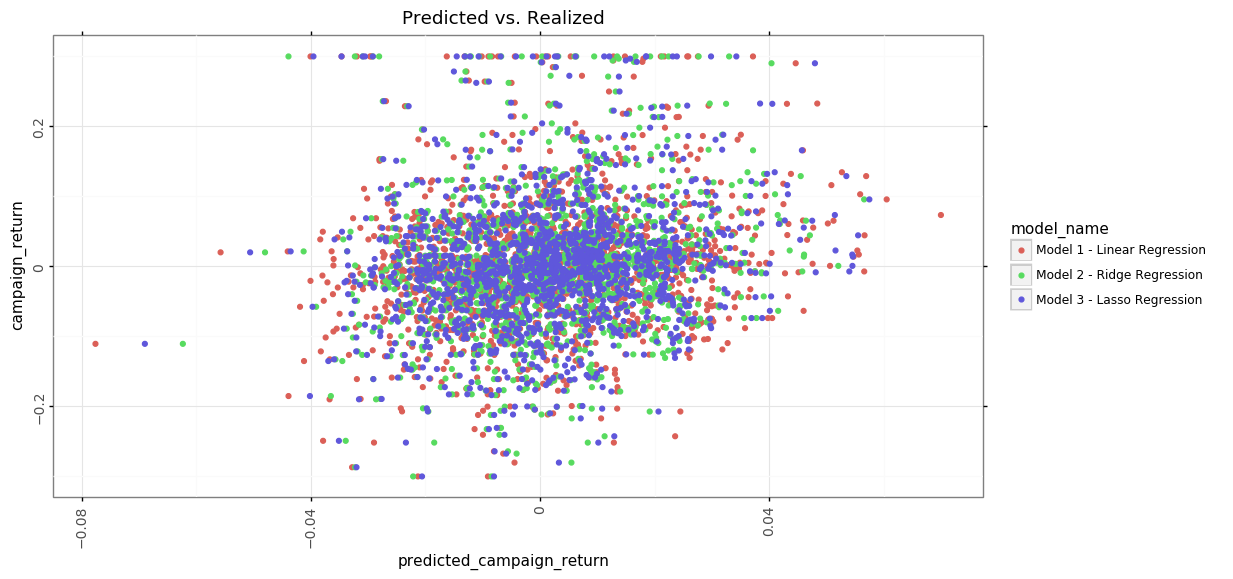

<ggplot: (140919651830)>

In [34]:
(
    gg.ggplot(df_test_predictions) +
    gg.geom_point(gg.aes(x='predicted_campaign_return', y='campaign_return', color='model_name')) +
    gg.theme(axis_text=gg.element_text(size=10, rotation=90), figure_size=(12, 6)) +
    gg.labs(
        title = "Predicted vs. Realized"
    )
)

In [64]:
pd.merge(
    df_coefficients.loc[lambda df: df.model_name.str.contains('3')],
    df_predictions.loc[df_predictions.campaign_id == "1073549494C", [c for c in df_coefficients.variable]].transpose().reset_index().rename(columns=dict(index='variable')),
    on='variable', how='left'
)

,model_name,variable_id,variable,coefficient,9467,9467,9467
0,Model 3 - Lasso Regression,43,governance_demand=Remove Directors,-0.022751,0.000000,0.000000,0.000000
1,Model 3 - Lasso Regression,43,governance_demand=Remove Directors,-0.022751,0.000000,0.000000,0.000000
2,Model 3 - Lasso Regression,43,governance_demand=Remove Directors,-0.022751,0.000000,0.000000,0.000000
3,Model 3 - Lasso Regression,28,campaign_objective=Short,-0.016326,0.000000,0.000000,0.000000
4,Model 3 - Lasso Regression,28,campaign_objective=Short,-0.016326,0.000000,0.000000,0.000000
5,Model 3 - Lasso Regression,28,campaign_objective=Short,-0.016326,0.000000,0.000000,0.000000
6,Model 3 - Lasso Regression,26,campaign_objective=Generic Objective,-0.014138,0.000000,0.000000,0.000000
7,Model 3 - Lasso Regression,26,campaign_objective=Generic Objective,-0.014138,0.000000,0.000000,0.000000
8,Model 3 - Lasso Regression,26,campaign_objective=Generic Objective,-0.014138,0.000000,0.000000,0.000000
9,Model 3 - Lasso Regression,32,value_demand=Capital Structure,-0.012278,0.000000,0.000000,0.000000


C:\Users\micha\AppData\Local\Continuum\anaconda3\lib\site-packages\plotnine\scales\scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
C:\Users\micha\AppData\Local\Continuum\anaconda3\lib\site-packages\plotnine\utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


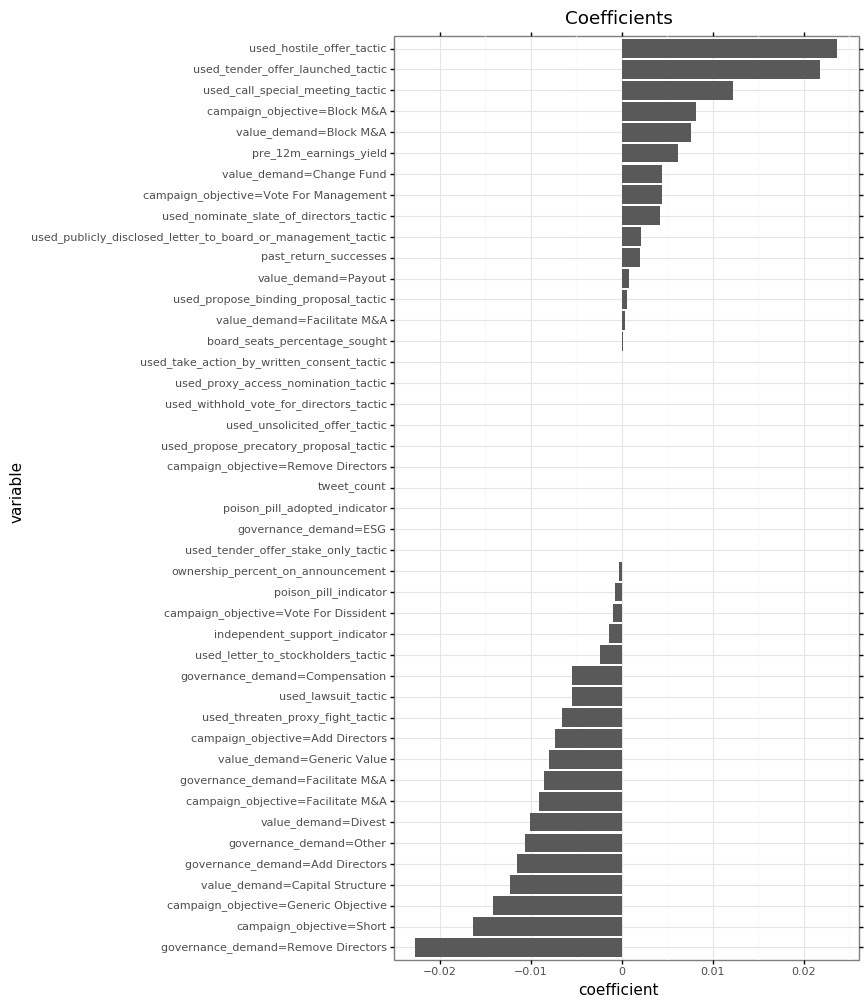

<ggplot: (-9223371884839274415)>

In [45]:
df_coefficients = (
    pd.DataFrame({
    'variable': X_train.columns.tolist(),
    'coefficient': dict_models_optimized["Model 3 - Lasso Regression"].named_steps['model'].coef_.flatten().tolist(),
    })
    .sort_values('coefficient')
    .assign(variable=lambda df: pd.Categorical(df.variable, categories=df.variable.tolist()))
)

(
    gg.ggplot(df_coefficients) +
    gg.geom_bar(gg.aes(x='variable', y='coefficient'), stat='identity', position='dodge') +
    gg.theme(axis_text=gg.element_text(size=8, rotation=0), figure_size=(6, 12)) +
    gg.coord_flip() +
    gg.labs(
        title = "Coefficients"
    )
)

C:\Users\micha\AppData\Local\Continuum\anaconda3\lib\site-packages\plotnine\scales\scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
C:\Users\micha\AppData\Local\Continuum\anaconda3\lib\site-packages\plotnine\utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


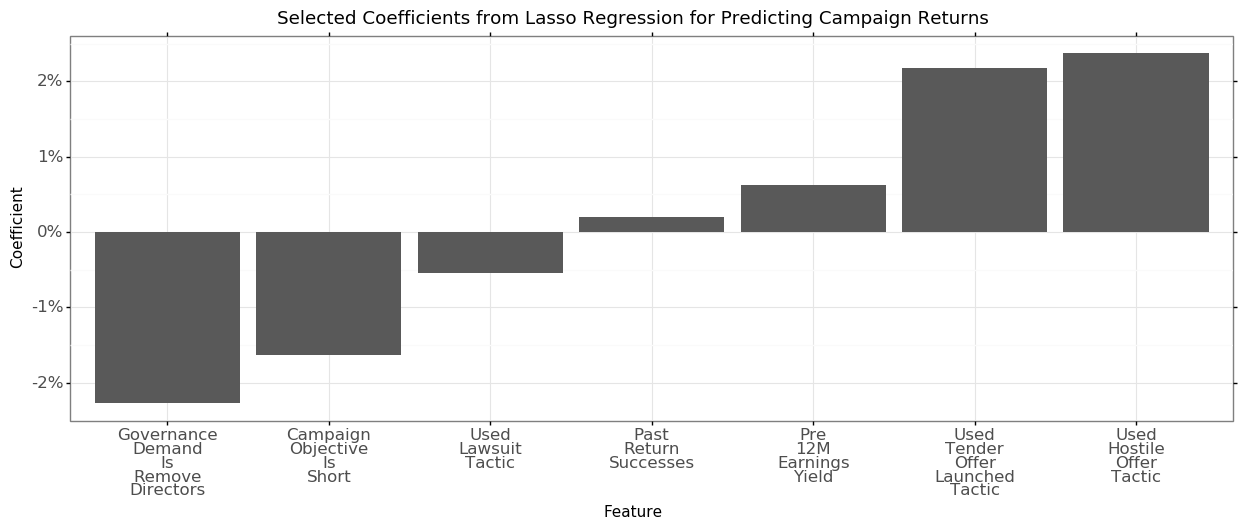

<ggplot: (152014164551)>

In [49]:
df_coefficients = (
    pd.concat({
        model_name: pd.DataFrame({
            'variable': X_train.columns.tolist(),
            'coefficient': model.named_steps['model'].coef_.flatten().tolist()
        })
        for model_name, model in dict_models_optimized.items()
    }, names=['model_name', 'variable_id'])
    .reset_index()
    .sort_values(['model_name', 'coefficient'])
    .assign(variable=lambda df: pd.Categorical(df.variable, categories=df[df.model_name == "Model 3 - Lasso Regression"].variable.unique().tolist()))
)

gg.theme_set(gg.theme_bw())

(
    gg.ggplot(
        df_coefficients
        .loc[lambda df: df.model_name == "Model 3 - Lasso Regression"]
        .loc[lambda df: df.coefficient != 0]
        .assign(is_special=lambda df: df.variable.isin([
            'tweet_count',
            'used_lawsuit_tactic',
            'past_return_successes',
            #'value_demand=Payout',
            'governance_demand=Remove Directors',
            'campaign_objective=Short',
            #'independent_support_indicator',
            # 'used_nominate_slate_of_directors_tactic',
            'pre_12m_earnings_yield',
            'used_tender_offer_launched_tactic',
            'used_hostile_offer_tactic',
            # 'has_past_return_successes_indicator'
        ]))
        .loc[lambda df: df.is_special == True]
        # .loc[lambda df: df.coefficient >= -0.00]
        .assign(variable=lambda df: df.variable.str.replace('=', ' is ').str.replace(' ', '\n').str.replace('_' ,'\n').str.title())
        .sort_values(['model_name', 'coefficient'])
        .assign(variable=lambda df: pd.Categorical(df.variable, categories=df.variable.unique().tolist()))
    ) +
    gg.geom_bar(gg.aes(x='variable', y='coefficient'), stat='identity', position='dodge') +
    gg.theme(axis_text=gg.element_text(size=12, rotation=0), figure_size=(15, 5)) +
    gg.scale_y_continuous(labels=lambda l: [f"{v * 100:.0f}%" for v in l]) +
    gg.scale_fill_brewer(palette=1, guide=False) +
    # gg.coord_flip() +
    gg.labs(
        title = "Selected Coefficients from Lasso Regression for Predicting Campaign Returns",
        x = "Feature",
        y = "Coefficient"
    )
)

In [114]:
df_coefficients.head(1)

,model_name,variable_id,variable,coefficient
46,Model 3 - Lasso Logistic Regression,46,NaN,-0.434859


# Models for Classification of Returns

## scikit classification

In [96]:
x_columns = (
    [
        'ownership_percent_on_announcement',
        'ownership_percent_exceeds_5_indicator',
        'past_return_successes',
        'independent_support_indicator',
        'total_number_of_board_seats',
        'board_seats_percentage_sought',
        'poison_pill_indicator',
        'poison_pill_adopted_indicator',
        'pre_12m_earnings_yield',
        'tweet_count',
        'beta'
    ] +
    [c for c in df.columns.tolist() if 'used_' in c] +
    [c for c in df.columns.tolist() if 'campaign_objective=' in c] +
    [c for c in df.columns.tolist() if 'value_demand=' in c] +
    [c for c in df.columns.tolist() if 'governance_demand=' in c]
)

y_column = [
    'campaign_return_is_positive'
]

df_lm = df.dropna(subset=y_column)
df_train, df_test = train_test_split(df_lm, test_size=0.2, shuffle=True, random_state=777, stratify=df_lm[y_column])
df_full = df_lm[x_columns + y_column]
X_train, y_train = df_train[x_columns], df_train[y_column].values.ravel()
X_test, y_test = df_test[x_columns], df_test[y_column].values.ravel()
n_samples, n_features = X_train.shape

In [97]:
categorical_features = [c for c in df_full.dtypes[df_full.dtypes != float].index.tolist() if c not in y_column]
numeric_features = [c for c in df_full.dtypes[df_full.dtypes == float].index.tolist() if c not in y_column]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    # ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('numeric', numeric_transformer, numeric_features),
    ('categorical', categorical_transformer, categorical_features)
])

dict_model_pipelines = {
    # "Model 1 - Logistic Regression": [
    #     ('preprocessor', preprocessor),
    #     ("model", LogisticRegression(penalty='none', solver='lbfgs', tol=0.001, max_iter=1000))
    # ],
    # "Model 2 - Ridge Logistic Regression": [
    #     ('preprocessor', preprocessor),
    #     ("model", LogisticRegression(penalty='l2', solver='lbfgs', tol=0.001, max_iter=1000))
    # ],
    "Model 3 - Lasso Logistic Regression": [
        ('preprocessor', preprocessor),
        ("model", LogisticRegression(penalty='l1', solver='liblinear', tol=0.001, max_iter=1000))
    ]
}

dict_model_parameter_grids = {
    "Model 1 - Logistic Regression": {},
    "Model 2 - Ridge Logistic Regression": {
        'model__C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
    },
    "Model 3 - Lasso Logistic Regression": {
        'model__C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]
    }
}

dict_grid_search_params = {
    "scoring": 'accuracy',
    "cv": 5,
    "refit": True,
    "iid": True
}

dict_cv_params = {
    "scoring": 'accuracy',
    "cv": 5
}

In [98]:
dict_models_baseline = {}
dict_grids = {}
dict_models_optimized = {}
dict_scores = {}
dict_train_predicted = {}
dict_test_predicted = {}

for model_name, model_pipeline_parameters in dict_model_pipelines.items():
    
    print('running model {}...'.format(model_name))
    print('=' * 100)
    print('')
    
    # model parameters
    
    pipeline_baseline_parameters = dict_model_pipelines[model_name].copy()
    grid_search_parameters = dict_model_parameter_grids[model_name].copy()
    pipeline_optimized_parameters = dict_model_pipelines[model_name].copy()  # will be updated
    
    # baseline fit on full training data
    
    model_pipeline_basline = Pipeline(pipeline_baseline_parameters)
    model_pipeline_basline = model_pipeline_basline.fit(X_train, y_train)

    params_baseline = model_pipeline_basline.get_params(deep=True)
    
    score_baseline_train = model_pipeline_basline.score(X_train, y_train)
    score_baseline_validation = np.mean(cross_val_score(model_pipeline_basline, X_train, y_train, **dict_cv_params))
    score_baseline_test = model_pipeline_basline.score(X_test, y_test)
    
    print('simple fit on training sample')
    print('-' * 80)
    print('')
    print('full-sample baseline parameters: {}'.format(params_baseline['model']))
    print('full-sample baseline train score: {}'.format(score_baseline_train))
    print('full-sample baseline validation score: {}'.format(score_baseline_validation))
    print('full-sample baseline test score: {}'.format(score_baseline_test))
    print('')
    
    # grid fit on cv-samples of training data

    model_grid_pipeline = Pipeline(pipeline_baseline_parameters)
    model_grid = GridSearchCV(model_grid_pipeline, param_grid=grid_search_parameters, **dict_grid_search_params)
    model_grid = model_grid.fit(X_train, y_train)
    
    params_grid_best = model_grid.best_params_.copy()
    
    score_grid_train = model_grid.score(X_train, y_train)
    score_grid_validation = np.mean(cross_val_score(model_grid, X_train, y_train, **dict_cv_params))
    score_grid_test = model_grid.score(X_test, y_test)

    print('cv fit on training sample')
    print('-' * 80)
    print('')
    print('grid-search-cv best parameters: {}'.format(params_grid_best))
    print('grid-search-cv best train score: {}'.format(score_grid_train))
    print('grid-search-cv best validation score: {}'.format(score_grid_validation))
    print('grid-search-cv best test score: {}'.format(score_grid_test))
    print('')
    
    # optimized fit on full training data
    
    model_pipeline_optimized = Pipeline(pipeline_optimized_parameters)
    model_pipeline_optimized.set_params(**params_grid_best)
    model_pipeline_optimized = model_pipeline_optimized.fit(X_train, y_train)

    params_optimized = model_pipeline_optimized.get_params(deep=True)
    
    score_optimized_train = model_pipeline_optimized.score(X_train, y_train)
    score_optimized_validation = np.mean(cross_val_score(model_pipeline_optimized, X_train, y_train, **dict_cv_params))
    score_optimized_test = model_pipeline_optimized.score(X_test, y_test)
    
    print('optimized fit on training sample')
    print('-' * 80)
    print('')
    print('full-sample optimized parameters: {}'.format(params_optimized['model']))
    print('full-sample optimized train score: {}'.format(score_optimized_train))
    print('full-sample optimized validation score: {}'.format(score_optimized_validation))
    print('full-sample optimized test score: {}'.format(score_optimized_test))
    print('')
    
    # final prediction
    
    y_train_predicted = model_pipeline_optimized.predict(X_train)
    y_test_predicted = model_pipeline_optimized.predict(X_test)
    
    df_train_predicted = df_train.assign(predicted_campaign_return=y_train_predicted).assign(model_name=model_name)
    df_test_predicted = df_test.assign(predicted_campaign_return=y_test_predicted).assign(model_name=model_name)

    # store
    dict_models_baseline[model_name] = model_pipeline_basline
    dict_grids[model_name] = model_grid.cv_results_
    dict_models_optimized[model_name] = model_pipeline_optimized
    dict_scores[model_name] = pd.DataFrame(
        columns=['IsTuned', 'Sample', 'Score'],
        data={
            'IsTuned': [
                False, False, False,
                True, True, True
            ],
            'Sample': [
                'Train', 'Validation', 'Test',
                'Train', 'Validation', 'Test'
            ],
            'Score': [
                score_baseline_train, score_baseline_validation, score_baseline_test,
                score_optimized_train, score_optimized_validation, score_optimized_test
            ]
        },
    ).set_index(['IsTuned', 'Sample'])
    dict_train_predicted[model_name] = df_train_predicted
    dict_test_predicted[model_name] = df_test_predicted

running model Model 3 - Lasso Logistic Regression...

simple fit on training sample
--------------------------------------------------------------------------------

full-sample baseline parameters: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.001, verbose=0,
                   warm_start=False)
full-sample baseline train score: 0.5815568475452196
full-sample baseline validation score: 0.568962429485677
full-sample baseline test score: 0.5887669464170433

cv fit on training sample
--------------------------------------------------------------------------------

grid-search-cv best parameters: {'model__C': 0.1}
grid-search-cv best train score: 0.5776808785529716
grid-search-cv best validation score: 0.5718682592691937
grid-search-cv best test score: 0.5952227

In [61]:
df_scores = pd.concat(dict_scores, names=['Model', 'IsTuned', 'Sample']).reset_index().loc[lambda df: df.IsTuned == True]
df_train_predictions = pd.concat(dict_train_predicted.values())
df_test_predictions = pd.concat(dict_test_predicted.values())

In [62]:
df_scores[['Model', 'Sample', 'Score']].set_index(['Model', 'Sample']).unstack('Sample')

Score                     
Sample                           Test     Train Validation
Model                                                     
Model 1 - Linear Regression -0.000638  0.045215   0.030563
Model 2 - Ridge Regression   0.005635  0.042310   0.031876
Model 3 - Lasso Regression   0.002661  0.043787   0.032678

In [99]:
df_coefficients = (
    pd.concat({
        model_name: pd.DataFrame({
            'variable': x_columns,
            'coefficient': model.named_steps['model'].coef_.flatten().tolist()
        })
        for model_name, model in dict_models_optimized.items()
    }, names=['model_name', 'variable_id'])
    .reset_index()
    .sort_values(['model_name', 'coefficient'])
    .assign(variable=lambda df: pd.Categorical(df.variable, categories=df[df.model_name == "Model 3 - Lasso Logistic Regression"].variable.unique().tolist()))
    .assign(odds_coefficient=lambda df: np.exp(df.coefficient))
    .assign(probability_coefficient=lambda df: df.odds_coefficient / (1 + df.odds_coefficient) - 0.50)
    .assign(probability_baseline=0.50)
)

# (
#     gg.ggplot(df_coefficients) +
#     gg.geom_bar(gg.aes(x='variable', y='probability_coefficient', fill='model_name'), stat='identity', position='dodge') +
#     gg.geom_hline(gg.aes(yintercept='probability_baseline')) +
#     gg.theme(axis_text=gg.element_text(size=8, rotation=0), figure_size=(6, 12), legend_position=(0.5, 0.0)) +
#     gg.coord_flip() +
#     gg.labs(
#         title = "Coefficients from Predicting Campaign Returns is Positive",
#         y = "Probability Implied from Coefficient",
#         x = "Variable"
#     )
# )

In [92]:
df_coefficients.head(1)

,model_name,variable_id,variable,coefficient,odds_coefficient,probability_coefficient,probability_baseline
16,Model 1 - Logistic Regression,16,used_proxy_access_nomination_tactic,-5.341707,0.004788,-0.495235,0.5


C:\Users\micha\AppData\Local\Continuum\anaconda3\lib\site-packages\plotnine\scales\scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
C:\Users\micha\AppData\Local\Continuum\anaconda3\lib\site-packages\plotnine\utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


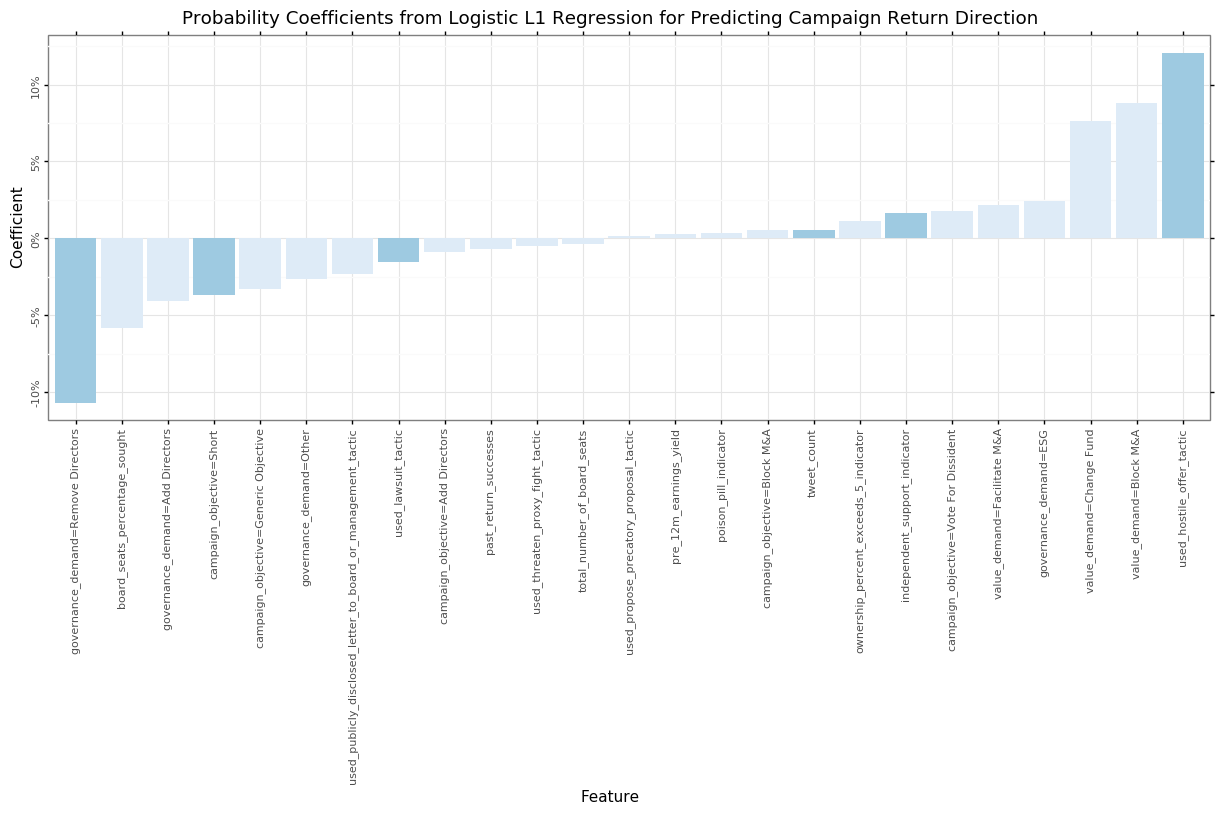

<ggplot: (-9223371865457186595)>

In [107]:
(
    gg.ggplot(
        df_coefficients
        .loc[lambda df: df.model_name == "Model 3 - Lasso Logistic Regression"]
        .loc[lambda df: df.probability_coefficient != 0]
        .assign(is_special=lambda df: df.variable.isin(['tweet_count', 'used_lawsuit_tactic', 'value_demand=Payout', 'governance_demand=Remove Directors', 'campaign_objective=Short', 'independent_support_indicator', 'used_hostile_offer_tactic']))
    ) +
    gg.geom_bar(gg.aes(x='variable', y='probability_coefficient', fill='is_special'), stat='identity', position='dodge') +
    gg.theme(axis_text=gg.element_text(size=8, rotation=90), figure_size=(15, 5)) +
    gg.scale_y_continuous(labels=lambda l: ["%d%%" % (v * 100) for v in l]) +
    gg.scale_fill_brewer(palette=1, guide=False) +
    # gg.coord_flip() +
    gg.labs(
        title = "Probability Coefficients from Logistic L1 Regression for Predicting Campaign Return Direction",
        x = "Feature",
        y = "Coefficient"
    )
)

In [ ]:
df.groupby(['campaign_objective=Facilitate M&A', 'proxy_result=Management', 'campaign_return_is_positive']).campaign_id.count()

In [ ]:
df.groupby(['campaign_objective=Block M&A', 'proxy_result=Management', 'campaign_return_is_positive']).campaign_id.count()

In [ ]:
#### df.groupby(['campaign_objective=Short', 'board_result=Management', 'campaign_return_is_positive']).campaign_id.count()

In [11]:
final_model = dict_models_optimized['Model 3 - Lasso Logistic Regression']

In [12]:
from joblib import dump, load
dump(final_model, '../results/campaign_return_model.joblib') 

['../results/campaign_return_model.joblib']

In [32]:
df_lm[['campaign_id'] + x_columns].to_csv('../results/campaign_return_model_data.csv', index=False)

In [49]:
df_campaign_return_data = pd.read_csv('../results/campaign_return_model_data.csv')
campaign_return_model = load('../results/campaign_return_model.joblib') 

In [50]:
df_x = df_campaign_return_data[lambda df: df.campaign_id == df.campaign_id.sample(1).iloc[0]].iloc[:, 1::]

In [51]:
df_x

,ownership_percent_on_announcement,ownership_percent_exceeds_5_indicator,past_return_successes,independent_support_indicator,poison_pill_indicator,poison_pill_adopted_indicator,pre_12m_earnings_yield,earnings_yield_at_announcement,used_call_special_meeting_tactic,used_hostile_offer_tactic,...,used_unsolicited_offer_tactic,used_withhold_vote_for_directors_tactic,campaign_objective=Add Directors,campaign_objective=Block M&A,campaign_objective=Facilitate M&A,campaign_objective=Generic Objective,campaign_objective=Remove Directors,campaign_objective=Short,campaign_objective=Vote For Dissident,campaign_objective=Vote For Management
3824,0.2,1,12.0,0,1,0,0.532411,0.004443,0,0,...,0,0,1,0,0,0,0,0,0,0


In [48]:
pd.DataFrame({
    'variable': df_x.columns.tolist(),
    'coefficient': campaign_return_model.named_steps['model'].coef_.flatten().tolist(),
    'value': df_x.values.flatten()
})



,variable,coefficient,value
0,ownership_percent_on_announcement,0.000000,0.0
1,ownership_percent_exceeds_5_indicator,0.033783,0.0
2,past_return_successes,0.000000,NaN
3,independent_support_indicator,0.236788,0.0
4,poison_pill_indicator,0.038531,0.0
5,poison_pill_adopted_indicator,0.000000,0.0
6,pre_12m_earnings_yield,0.009298,NaN
7,earnings_yield_at_announcement,0.000000,NaN
8,used_call_special_meeting_tactic,0.000000,0.0
9,used_hostile_offer_tactic,0.474209,0.0


[0.0,
 0.03378283433599393,
 0.0,
 0.23678798137527282,
 0.03853135521847032,
 0.0,
 0.00929765880217275,
 0.0,
 0.0,
 0.47420914410492615,
 0.0,
 0.0,
 0.0,
 0.0,
 0.06122270275392558,
 0.0,
 -0.10203581051961044,
 0.0,
 0.026902696656006062,
 0.0,
 -0.050590846833495406,
 0.11270703232064279,
 0.0,
 -0.07410213330580569,
 0.295169065947902,
 0.0,
 -0.1205296484666432,
 0.0,
 -0.3292116567372439,
 0.0,
 0.0]

In [22]:
campaign_return_model.predict(df_campaign_return_data.sample(1))

array([1.])

In [14]:
x_columns = (
    [
        'ownership_percent_on_announcement',
        'ownership_percent_exceeds_5_indicator',
        'past_return_successes',
        'independent_support_indicator',
        'poison_pill_indicator',
        'poison_pill_adopted_indicator',
        'pre_12m_earnings_yield',
        'earnings_yield_at_announcement'
    ] +
    [c for c in df.columns.tolist() if 'used_' in c] +
    [c for c in df.columns.tolist() if 'campaign_objective=' in c]
    # [c for c in df.columns.tolist() if 'value_demand=' in c] +
    # [c for c in df.columns.tolist() if 'governance_demand=' in c]
)

## Graphical Model Classification

In [ ]:
x_columns = (
    [
        'ownership_percent_exceeds_5_indicator',
        'has_past_return_successes_indicator',
        'independent_support_indicator',
        'poison_pill_indicator',
        'poison_pill_adopted_indicator',
        'campaign_objective_group'
    ] 
)

z_column = ['campaign_outcome_is_management']

y_column = ['campaign_return_is_positive']

all_columns = x_columns + z_column + y_column

df_pgm = df_original[all_columns].dropna(subset=y_column)

df_train, df_test = train_test_split(df_pgm, test_size=0.2, shuffle=True, random_state=777, stratify=df_pgm[y_column])
df_full = df_pgm[x_columns + y_column]

X_train, y_train = df_train[x_columns], df_train[y_column].values.ravel()
X_test, y_test = df_test[x_columns], df_test[y_column].values.ravel()
n_samples, n_features = X_train.shape

In [ ]:
x_columns

In [ ]:
df_train.isnull().sum()

In [ ]:
df_train.head()

In [ ]:
model = BayesianModel(
    [(x_column, y_column[0]) for x_column in x_columns] 
)

model.fit(
    df_train,
    estimator=BayesianEstimator,
    complete_samples_only=True
)

inference = VariableElimination(model)

In [ ]:
model.nodes()

In [ ]:
model.edges()

In [ ]:
# model.get_independencies()

In [ ]:
#for cpd in model.get_cpds():
#    print("CPD of {variable}:".format(variable=cpd.variable))
#    print(cpd)

In [ ]:
result = inference.query(variables=['campaign_return_is_positive'], evidence={'has_past_return_successes_indicator': 0})
print(result['campaign_return_is_positive'])

In [ ]:
result = inference.query(variables=['campaign_return_is_positive'], evidence={'has_past_return_successes_indicator': 1})
print(result['campaign_return_is_positive'])

In [ ]:
df_train_predicted = (
    df_train
    .assign(campaign_return_predicted_positive=model.predict(df_train[x_columns]))
    .assign(is_correct=lambda df: 1 * (df.campaign_return_is_positive == df.campaign_return_predicted_positive))
)

In [ ]:
(df_train_predicted.campaign_return_predicted_positive.astype(bool) & df_train_predicted.is_correct.astype(bool)).sum() / df_train_predicted.campaign_return_predicted_positive.sum()

In [ ]:
df_test_predicted = (
    df_test
    .assign(campaign_return_predicted_positive=model.predict(df_test[x_columns]))
    .assign(is_correct=lambda df: 1 * (df.campaign_return_is_positive == df.campaign_return_predicted_positive))
)

In [ ]:
(df_test_predicted.campaign_return_predicted_positive.astype(bool) & df_test_predicted.is_correct.astype(bool)).sum() / df_test_predicted.campaign_return_predicted_positive.sum()

In [ ]:
import networkx as nx
import pylab as plt

plt.figure(figsize=(12, 12))
nx.draw(model, with_labels=True)
plt.show()